In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
import PyImbalReg as pir
import pandas as pd
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import resreg
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score

In [2]:
df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_fuller_df.csv")

In [3]:
def label_func(faultD):
  if(faultD == 0): return 0
  elif(faultD < 500): return 1
  else: return 2



def reg_acc(md, data, test_labels):
  test_predictions = md.predict(data).flatten()
  r2 = r2_score(test_labels, test_predictions)
  rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))
  mae = mean_absolute_error(test_labels, test_predictions)

  print(f'r2 score: {r2}')
  print(f'rmse score: {rmse}')
  print(f'mae score: {mae}')
  # print(f'erro medio de: {rmse} segundos')

  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-100, 100], [-100, 100])

def bin_func(faultD):
  if(faultD == 0): return 0
  else: return (faultD//500 + 1)


def show_results(y_test, predictions):
  print('Accuracy score:', accuracy_score(y_test, predictions))
  # print('f1 score:', f1_score(y_test, predictions))
  # print('recall score:', recall_score(y_test, predictions))

  font = {'family' : 'serif', 'weight' : 'bold', 'size':18}
  plt.rc('font', **font)
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=None)
  disp.plot()
  plt.show()

In [4]:
df = df.sample(frac=1)
test_data = df[:(len(df)//5)]
train_data = df[(len(df)//5):]

test_data['bin'] = test_data.fault_duration.apply(bin_func)
test_data['fault'] = test_data['fault_duration'].apply(label_func)
test_data['is_fault'] = test_data.fault.apply(lambda x: 0 if x == 0 else 1)

X_test = test_data.drop(columns=['Unnamed: 0','NE ID','endTime', 'relation','fault_duration','bin','fault','is_fault']).values
y_test_fd = test_data.fault_duration.values
y_test = test_data.fault_duration.apply(label_func).values

train_data['fault'] = train_data['fault_duration'].apply(label_func)
train_data = train_data.dropna()
train_data = train_data.drop(columns=['Unnamed: 0','NE ID','endTime','relation'])
train_data['bin'] = train_data.fault_duration.apply(bin_func)
train_data['is_fault'] = train_data.fault.apply(lambda x: 0 if x == 0 else 1)

/tmp/ipykernel_4828/150606986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['bin'] = test_data.fault_duration.apply(bin_func)
/tmp/ipykernel_4828/150606986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['fault'] = test_data['fault_duration'].apply(label_func)
/tmp/ipykernel_4828/150606986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [5]:
y = train_data.fault.values
X = train_data.drop(columns=['fault','fault_duration','is_fault','bin']).values

faults = train_data[train_data['fault_duration'] > 0]
X_fault = faults.drop(columns=['fault','fault_duration']).values
y_fault = faults.is_fault.values


In [6]:
def score(y_true, y_pred):
    rec_arr = recall_score(y_true, y_pred, average=None)
    return rec_arr[0]*0.25 + rec_arr[1]*0.25 + rec_arr[2]*0.5

In [8]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

params = {'n_estimators': 94, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1}
rf = RandomForestClassifier(**params)
rf.fit(X_smote, y_smote)


dump(rf,'rf-model-customparam.joblib')


['rf-model-customparam.joblib']

Accuracy score: 0.9461493990567473


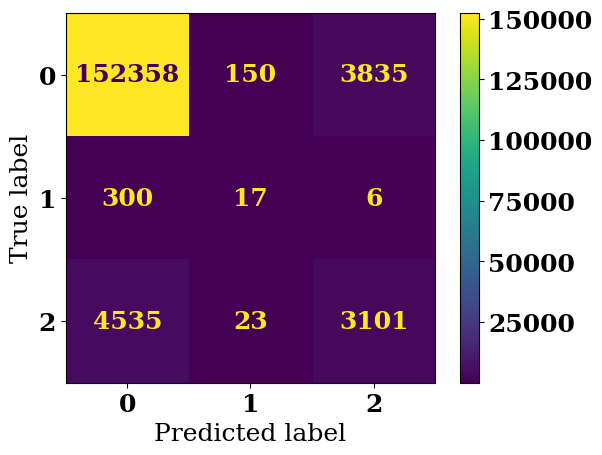

In [27]:
rf_pred = rf.predict(X_test)
show_results(y_test, rf_pred)

In [29]:
import plotly.express as px

fig = px.bar(x=train_data.drop(columns=['fault','fault_duration','is_fault','bin']).columns , y=rf.feature_importances_)
fig.show()

In [31]:
feat_imps = rf.feature_importances_

most_important = train_data.drop(columns=['fault','fault_duration','is_fault','bin']).columns[np.where(feat_imps > np.mean(feat_imps))]

In [57]:
most_important

Index(['resource_utilition_rate', 'TA', 'bler', 'cqi',
       'access_success_rate_rol_kurt', 'access_success_rate_rol_skew',
       'resource_utilition_rate_rol_mean', 'resource_utilition_rate_rol_std',
       'TA_rol_mean', 'TA_rol_std', 'bler_rol_mean', 'bler_rol_std',
       'cqi_rol_mean', 'cqi_rol_std', 'mcs_rol_mean', 'data_rate_rol_mean'],
      dtype='object')

In [50]:
X_most = X_smote[:, np.where(feat_imps > np.mean(feat_imps))]
X_most = X_most.reshape((X_most.shape[0], X_most.shape[2]))
X_test_most = X_test[:, np.where(feat_imps > np.mean(feat_imps))]
X_test_most = X_test_most.reshape((X_test_most.shape[0], X_test_most.shape[2]))

In [ ]:
rf_most = RandomForestClassifier(**params)
rf_most.fit(X_most, y_smote)


In [54]:
np.shape(X_most)

(1876263, 16)

Accuracy score: 0.9793823216187434


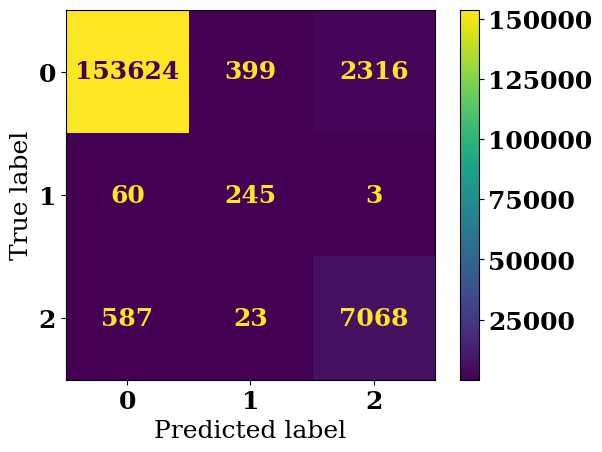

In [55]:
rf_most_pred = rf_most.predict(X_test_most)
show_results(y_test, rf_most_pred)

In [68]:
rf_most_proba = rf_most.predict_proba(X_test_most)

In [56]:
dump(rf_most,'rf-model-16mostimpfeat.joblib')

['rf-model-16mostimpfeat.joblib']

## PIPELINE

In [9]:
from imblearn.over_sampling import BorderlineSMOTE,ADASYN, KMeansSMOTE, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, EditedNearestNeighbours, RandomUnderSampler, TomekLinks
import itertools
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier

## oversample 
bds = BorderlineSMOTE()
ada = ADASYN()
kms = KMeansSMOTE(
    kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
sm = SMOTE()
ros = RandomOverSampler()

## undersample

cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
cnn = CondensedNearestNeighbour(random_state=42)  
enn = EditedNearestNeighbours()
rus = RandomUnderSampler(random_state=42)
tl = TomekLinks()


#models
params = {'n_estimators': 94, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1}
rf_pipe = RandomForestClassifier(**params)


In [15]:
most_important_feats = ['resource_utilition_rate', 'TA', 'bler', 'cqi',
       'access_success_rate_rol_kurt', 'access_success_rate_rol_skew',
       'resource_utilition_rate_rol_mean', 'resource_utilition_rate_rol_std',
       'TA_rol_mean', 'TA_rol_std', 'bler_rol_mean', 'bler_rol_std',
       'cqi_rol_mean', 'cqi_rol_std', 'mcs_rol_mean', 'data_rate_rol_mean']

feat_imps = []
for col in train_data.columns:
    if(col in most_important_feats):
        feat_imps.append(1)
    else:
        feat_imps.append(0)

In [18]:
X_pipe = X[:, np.where(feat_imps > np.mean(feat_imps))]
X_pipe = X_pipe.reshape((X_pipe.shape[0], X_pipe.shape[2]))
y_pipe = y

X_test_pipe = X_test[:, np.where(feat_imps > np.mean(feat_imps))]
X_test_pipe = X_test_pipe.reshape((X_test_pipe.shape[0], X_test_pipe.shape[2]))
y_test_pipe = y_test

In [70]:
def results(pipe, test, predictions):
    pipe_name = str(pipe) + "\n"
    acc = f"Accuracy: {accuracy_score(test, predictions)}\n"
    rec_arr = f"recall_scores : {recall_score(y_test, rf_most_pred, average=None)}\n"
    roc_arr = f"roc_auc_scores : {roc_auc_score(y_test, rf_most_proba, average=None, multi_class='ovr')}"
    f1_arr = f"f1_scores : {f1_score(y_test, rf_most_pred, average=None)}"

    text = pipe_name + acc + rec_arr + roc_arr + f1_arr

    return text

In [147]:
def run_pipeline_model(pipe, X_tr, y_tr, X_ts, y_ts, filename):

    print(type(X_tr))
    pipe = pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_ts)
    res = results(pipe, y_ts, y_pred)
    print(res)


    f = open(filename, "a")
    f.write(res)
    f.close()

In [148]:
from sklearn.base import BaseEstimator, TransformerMixin

class Resampler(BaseEstimator, TransformerMixin):
    def __init__(self, resampler):
        self.resampler = resampler

    def fit(self, X, y):
        return self  # Fit is just a placeholder

    def transform(self, X, y=None):
        print(f"{self.resampler} deu inicio ao resample ")
        if y is None:
            y = y_pipe # gambiarra louca 

        try:
            print(np.shape(X))
        except:
            X, y = X[0], X[1]
            print(X)

            
        try:
            # Verifica se o método fit_resample está disponível, senão usa fit_transform
            if hasattr(self.resampler, 'fit_resample'):
                X_resampled, y_resampled = self.resampler.fit_resample(X, y)
            else:
                X_resampled, y_resampled = self.resampler.fit_transform(X, y)
        
        except Exception as e:
            print(f"Erro no resample: {e}")
            raise e  # Relevante para debugging
            
        print(type(y_resampled))
        print(np.shape(y_resampled))
        return X_resampled, y_resampled

In [149]:
overs = [bds, ada, kms, sm, ros]
overs = [Resampler(o) for o in overs]
unders = [cc, cnn, enn, rus, tl]
unders = [Resampler(u) for u in unders]

models = [rf_pipe]
pipeline_comb = list(itertools.product(overs, unders, models))

In [23]:
np.shape(X_test_pipe)

(164325, 16)

In [150]:
for oversampler, undersampler, model in pipeline_comb:
    pipeline = Pipeline([
        ('oversampler', oversampler),
        ('undersampler', undersampler),
        ('classifier', model)
    ])

    run_pipeline_model(pipeline, X_pipe, y_pipe, X_test_pipe, y_test_pipe, "summary.txt")

<class 'numpy.ndarray'>
BorderlineSMOTE() deu inicio ao resample 
(657303, 16)
<class 'numpy.ndarray'>
(1876221,)
ClusterCentroids(estimator=MiniBatchKMeans(n_init=1, random_state=0),
                 random_state=42) deu inicio ao resample 
